In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from sklearn.impute import KNNImputer

# Input Data

In [2]:
df_val = pd.read_parquet('df_reponse_daily_validate.parquet')
df_train = pd.read_parquet('df_reponse_daily_train.parquet')
data = pd.concat([df_val,df_train])

In [3]:
data.head()

,stock_id,liq_weight,mktcap_weight,equal_weight,21d_next_raw,10d_next_raw,5d_next_raw,1d_next_raw,21d_next_mktAdj,10d_next_mktAdj,...,MOMENTUM,LEVERAGE,VALUE,EARNYLD,GROWTH,LTREV,STREV,industry_code,st_status,price
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:00,1,2.396226e+09,2.378102e+11,1.0,-0.002166,0.020939,-0.059206,-0.012274,-0.001094,0.018502,...,0.426806,0.571510,1.682973,0.525914,-0.003818,0.262610,-0.581015,28,0.0,41.006962
2018-01-02 10:00:00,2,2.024328e+09,3.178840e+11,1.0,0.096972,0.143775,0.093913,0.021719,0.098044,0.141338,...,0.553800,0.656238,0.049565,0.623254,0.642489,-0.808975,-0.825260,11,0.0,40.697322
2018-01-02 10:00:00,4,9.656266e+07,1.861763e+09,1.0,-0.055029,-0.008570,0.035634,0.006315,-0.053957,-0.011007,...,-0.778720,-0.815265,-1.849828,-0.659007,1.095353,0.000000,0.991848,4,0.0,22.170000
2018-01-02 10:00:00,5,1.272400e+08,4.414098e+09,1.0,-0.021583,0.019185,0.052758,0.028777,-0.020511,0.016748,...,-0.986298,-0.407534,-0.966078,-1.043719,1.424853,0.721478,0.590881,16,1.0,4.170000
2018-01-02 10:00:00,8,3.092281e+08,2.466039e+10,1.0,-0.061714,-0.042286,-0.033143,0.003429,-0.060642,-0.044723,...,-0.318160,-0.826986,-1.172774,-0.556188,-0.343901,0.138576,-0.434712,13,0.0,76.202135


In [4]:
#length of datasets
print(len(df_val))
print(len(df_train))
print(len(data))

2538128
4496616
7034744


In [5]:
#first we combine train and validate data to get the full data
#notice that the number of unique stocks in val, train, and full data are different, some stocks are delisted while others are newly listed
print(df_val['stock_id'].nunique())
print(df_train['stock_id'].nunique())
print(data['stock_id'].nunique())

4115
3459
4141


In [6]:
print(data.index.min())
print(data.index.max())

2010-01-04 10:00:00
2020-11-30 10:00:00


In [7]:
#let's use data only after 2014
data1 = data[data.index>'2014-12-31'].reset_index()

In [8]:
data1.columns

Index(['time', 'stock_id', 'liq_weight', 'mktcap_weight', 'equal_weight',
       '21d_next_raw', '10d_next_raw', '5d_next_raw', '1d_next_raw',
       '21d_next_mktAdj', '10d_next_mktAdj', '5d_next_mktAdj',
       '1d_next_mktAdj', '21d_next_styAdj', '10d_next_styAdj',
       '5d_next_styAdj', '1d_next_styAdj', 'SIZE', 'SIZENL', 'LIQUIDITY',
       'BETA', 'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE', 'EARNYLD', 'GROWTH',
       'LTREV', 'STREV', 'industry_code', 'st_status', 'price'],
      dtype='object')

# EDA

## Filling Missing Values

In [9]:
#seleting the price column
df_s = data1[['time','stock_id','1d_next_raw']]
df_series = df_s.pivot(index='time', columns='stock_id')

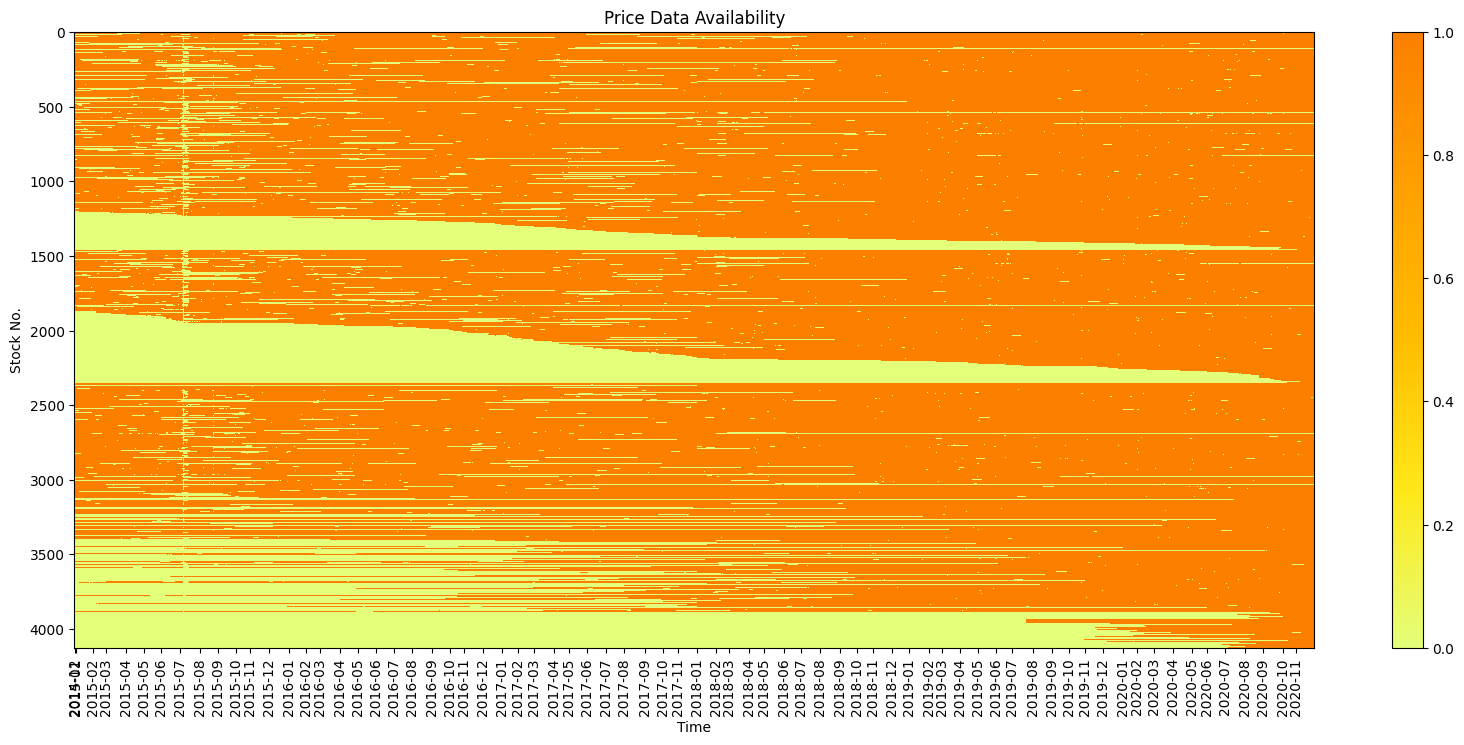

In [10]:
# Description of Nan Values among all data

data_presence = df_series.notna().astype(int)

# 绘制热图来表示数据的存在
plt.figure(figsize=(20, 8))
plt.imshow(data_presence.T, aspect='auto', cmap='Wistia', interpolation='nearest')

# 准备x轴标签
# 获取每个月的第一天
first_of_month = data_presence.index.to_series().resample('MS').min()
# 过滤掉NaT值
first_of_month = first_of_month.dropna()
# 计算日期在data_presence.index中的位置
first_of_month_positions = [data_presence.index.get_loc(date) for date in first_of_month]
# 准备标签
labels = [date.strftime('%Y-%m') for date in first_of_month]
plt.xticks(ticks=first_of_month_positions, labels=labels, rotation=90)

# 添加color bar
plt.colorbar()

# 添加标题和轴标签
plt.title('Price Data Availability')
plt.xlabel('Time')
plt.ylabel('Stock No.')

plt.show()

In [11]:
#statistic for non-null rows
stockids = ['stock_'+ str(id) for id in df_series.reset_index()['1d_next_raw'].columns]
df_clean = df_series.droplevel('stock_id', axis=1)
df_clean.columns = stockids

df_clean.count().describe()

count    4126.000000
mean     1067.412991
std       417.741751
min         1.000000
25%       865.000000
50%      1272.500000
75%      1380.000000
max      1419.000000
dtype: float64

In [13]:
#select only stocks that have no more than n consecutive days of missing data
def filter_consecutive_missing(df,threshold):
    df_nan_count = df.isnull().rolling(window=threshold, min_periods=1).sum()
    df_filtered = df.loc[:, (df_nan_count < threshold).all()]
    
    return df_filtered

#select only stocks that have more than n days data
def filter_total_missing(df,threshold):
    df_filtered = df.loc[:, df.count() > threshold]
    
    return df_filtered

def gen_random_columns(df):
    rand_indices = np.random.choice(len(df.columns), size=4, replace=False)
    rand_cols = df.columns[rand_indices]

    return rand_cols

#generate the plots random time series
def plot_random_time_series(df, rand_cols):
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))

    for i, column_name in enumerate(rand_cols):
        row = i // 2
        col = i % 2
        rand_series = df[column_name].fillna(0.000001)
        axs[row, col].scatter(rand_series.index, rand_series, marker='o', s=10, linestyle='-', label='daily return')
        axs[row, col].scatter(rand_series[rand_series == 0.000001].index, rand_series[rand_series == 0.000001], marker='x', s=10, color='red', label='Missing')  # Highlight values equal to 0.000001 with red
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel('1d_next_raw')
        axs[row, col].set_title(f'Random Time Series - {column_name}')
        axs[row, col].legend()
        axs[row, col].grid(True)

    plt.tight_layout()
    plt.show()

def fill_na_knn(df,k):
    imputer = KNNImputer(n_neighbors=k)
    
    return pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [16]:
#df_filtered = df_clean
df_filtered = filter_consecutive_missing(df_clean,10)
#df_filtered = filter_total_missing(df_filtered,710/2)
#df_filled = fill_na_knn(df_filtered,2)
len(df_filtered.columns)

645

### Another look at missing values for 4 random stocks

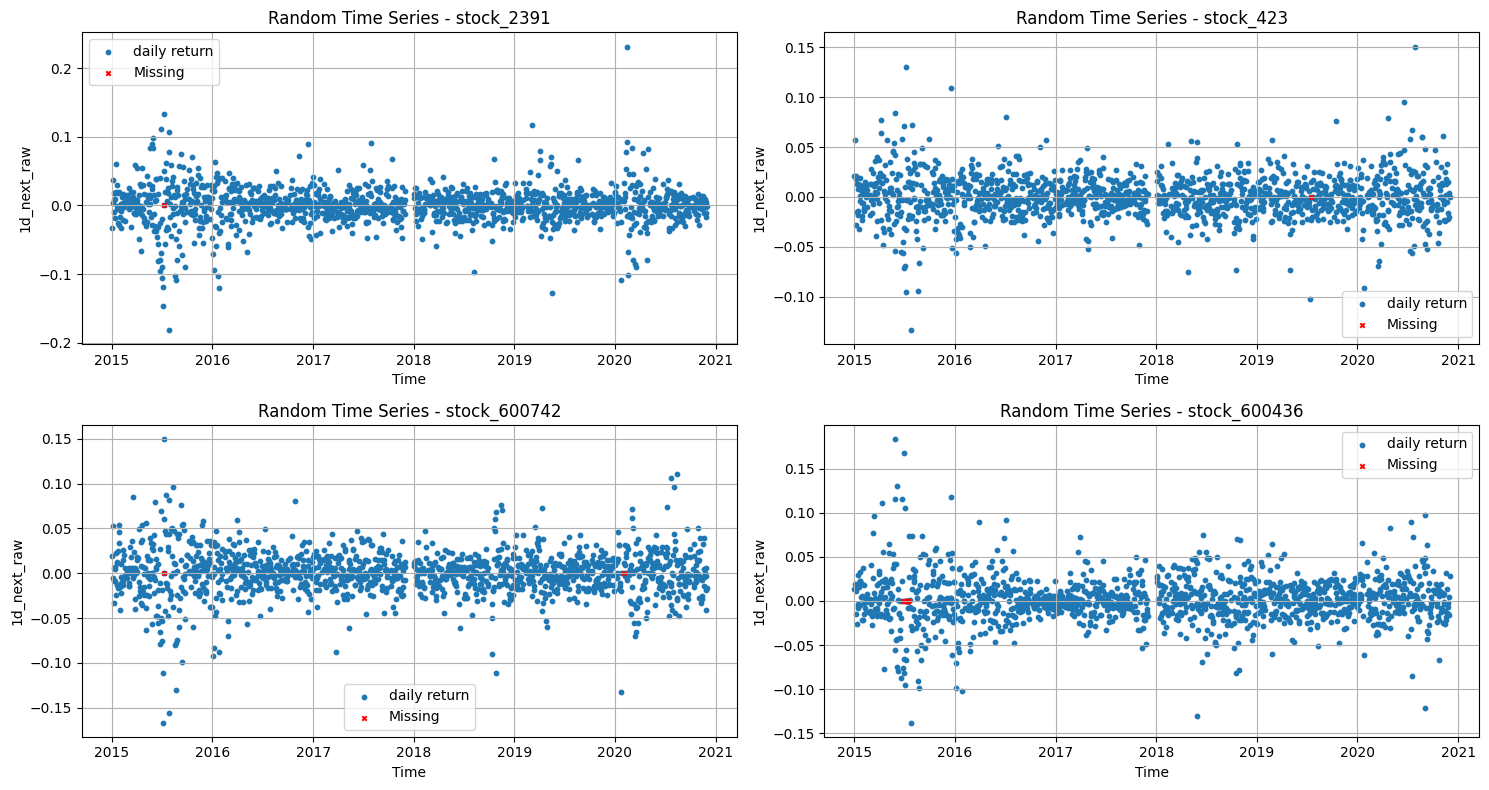

In [46]:
cols = gen_random_columns(df_filtered)
plot_random_time_series(df_filtered,cols)
#plot_random_time_series(df_filled,cols)

In [17]:
df_series = data1[['time', 'stock_id','21d_next_raw','SIZE', 'SIZENL', 'LIQUIDITY','BETA',
                'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE','EARNYLD', 'GROWTH','LTREV',
                'STREV', 'industry_code', 'st_status', 'price']].pivot(index='time', columns='stock_id')
df_series.columns = df_series.columns.get_level_values(0) + '_' + df_series.columns.get_level_values(1).astype(str)

In [18]:
df_series[['price_901', 'SIZENL_901', 'LIQUIDITY_901']].dropna()[145:155]

,price_901,SIZENL_901,LIQUIDITY_901
time,,,
2015-08-13 10:00:00,69.577980,0.941070,1.984182
2015-08-14 10:00:00,71.045766,0.939351,1.945138
2015-08-17 10:00:00,73.672979,0.943888,1.927915
2015-08-18 10:00:00,71.477468,0.933945,1.884898
2016-02-18 10:00:00,59.204805,0.000000,0.000000
2016-02-19 10:00:00,56.047216,0.820955,0.000000
2016-02-22 10:00:00,57.305318,0.852815,0.000000
2016-02-23 10:00:00,55.849866,0.870918,0.000000
2016-02-24 10:00:00,56.824279,0.876279,0.000000


In [19]:
def plot_columns(df, column_name_1, column_name_2, column_name_3):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first column as scatter plot
    axs[0].scatter(df.index, df[column_name_1], marker='o', s=10)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Price')
    axs[0].set_title('price')
    axs[0].tick_params(axis='x', rotation=45)

    # Plot the second column as scatter plot
    axs[1].scatter(df.index, df[column_name_2], marker='o', s=10)
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Price')
    axs[1].set_title('SIZENL')
    axs[1].tick_params(axis='x', rotation=45)

    # Plot the third column as scatter plot
    axs[2].scatter(df.index, df[column_name_3], marker='o', s=10)
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Price')
    axs[2].set_title('LIQUIDITY')
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

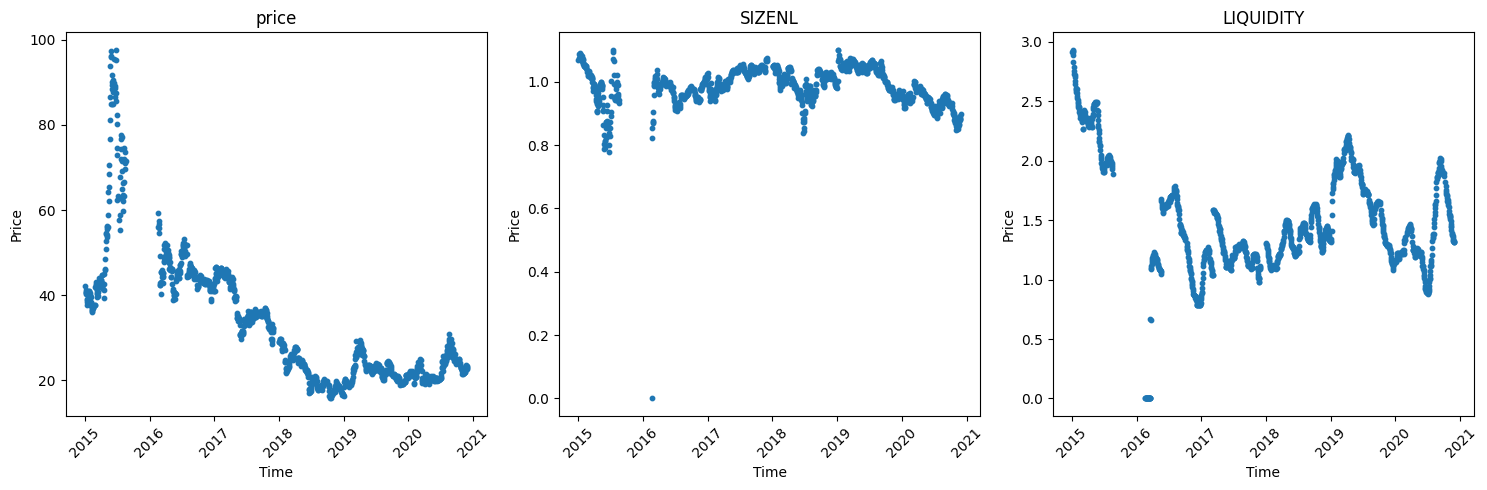

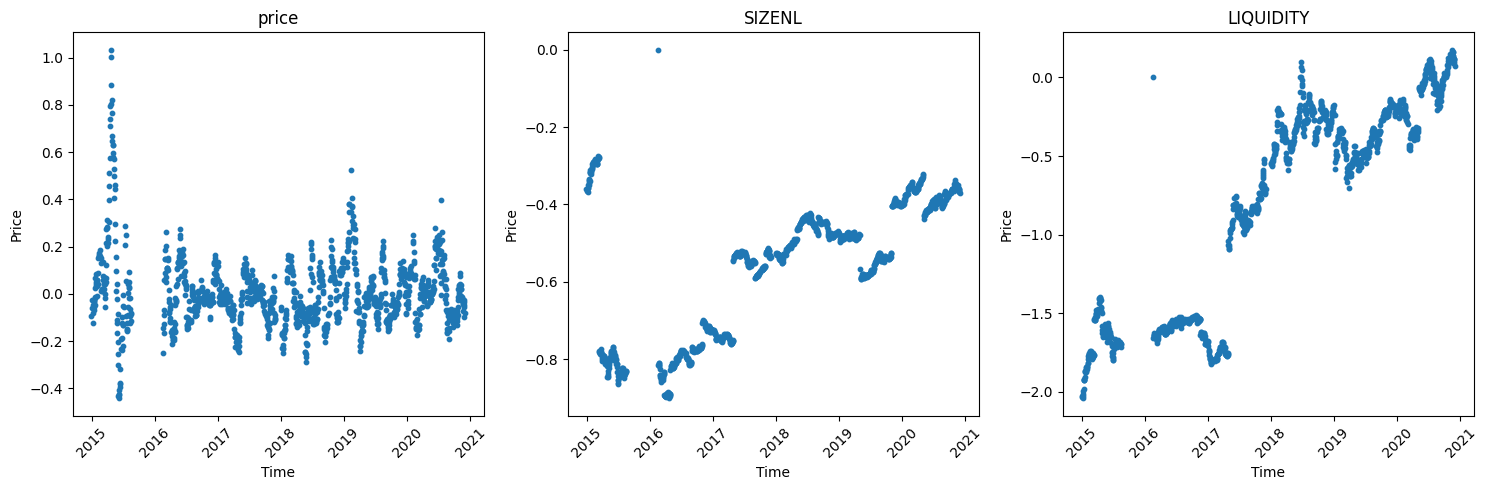

In [33]:
plot_columns(df_series, 'price_901', 'SIZENL_901', 'LIQUIDITY_901')
plot_columns(df_series, '21d_next_raw_901', 'LEVERAGE_901', 'VALUE_901')

# Extract Processed Data

In [20]:
#fill na with 0's
df_final1 = df_filtered.fillna(0)
df_final1.isna().sum().sum()

0

In [21]:
df_final = df_final1.rename(columns={'time': 'date'})
df_final.reset_index().head()

,time,stock_1,stock_11,stock_14,stock_25,stock_26,stock_27,stock_30,stock_36,stock_39,...,stock_603166,stock_603167,stock_603288,stock_603328,stock_603366,stock_603369,stock_603606,stock_603609,stock_603688,stock_603766
0,2014-12-31 10:00:00,0.040470,0.066667,0.071161,0.000000,0.004926,0.051804,0.011891,0.059361,0.020706,...,-0.077887,-0.015125,0.025967,0.015132,-0.000625,-0.012165,-0.031651,0.001412,-0.019032,0.050271
1,2015-01-05 10:00:00,0.014429,-0.031250,-0.039860,0.033000,0.014706,0.013193,-0.017626,-0.049569,0.027201,...,0.006497,0.055104,-0.004963,0.011499,0.020000,0.023904,0.020369,0.009873,0.031042,0.056701
2,2015-01-06 10:00:00,-0.041435,-0.009073,0.013110,-0.004840,0.026087,0.002604,0.053828,-0.002268,-0.035009,...,0.093897,-0.008562,0.032668,-0.000421,0.007966,0.006367,0.013463,0.012570,0.004839,0.001394
3,2015-01-07 10:00:00,-0.012903,0.007121,-0.017973,0.004864,0.011299,0.010390,0.047673,0.000000,-0.019535,...,0.003219,-0.017271,-0.003139,-0.000842,-0.009726,-0.027417,0.000458,0.036552,0.006421,0.006959
4,2015-01-08 10:00:00,-0.019608,-0.029293,0.006589,-0.001936,0.020484,-0.035133,0.002167,-0.013636,-0.005218,...,-0.042246,0.025483,0.007510,-0.008432,-0.001228,-0.001446,0.043956,0.009315,-0.000532,-0.013131


In [22]:
df_final.to_csv('data.csv')

# Scratch

In [35]:
df_series = data1[['time', 'stock_id','21d_next_raw','SIZE', 'SIZENL', 'LIQUIDITY','BETA',
                'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE','EARNYLD', 'GROWTH','LTREV',
                'STREV', 'industry_code', 'st_status', 'price']].pivot(index='time', columns='stock_id')
df_series.columns = df_series.columns.get_level_values(0) + '_' + df_series.columns.get_level_values(1).astype(str)

In [ ]:
no_nan_columns = df_series.columns[df_series.notna().all()]
no_nan_columns.str.split('_').str[-1].nunique()

In [ ]:
no_nan_columns_int = no_nan_columns.str.split('_').str[-1].unique().astype(int)

In [ ]:
df_1stock = df[df['stock_id']==596][['time','21d_next_raw','SIZE', 'SIZENL', 'LIQUIDITY','BETA',
                'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE','EARNYLD', 'GROWTH','LTREV',
                'STREV', 'price']]
df_1stock.to_csv('stock_596_21.csv', index=False)

In [ ]:
df_temp = df[df['stock_id'].isin(no_nan_columns_int)][['stock_id','industry_code']]
stocks_industry_30 = df_temp[df_temp['industry_code']==30]['stock_id'].unique()

In [ ]:
df_series = df[df['stock_id'].isin(stocks_industry_30)][['time','stock_id','1d_next_raw','SIZE', 'SIZENL', 'LIQUIDITY','BETA',
                'RESVOL', 'MOMENTUM', 'LEVERAGE', 'VALUE','EARNYLD', 'GROWTH','LTREV',
                'STREV', 'price']].pivot(index='time', columns='stock_id')
df_series.columns = df_series.columns.get_level_values(0) + '_' + df_series.columns.get_level_values(1).astype(str)
df_series.reset_index().to_csv('stock_402_nonan_industry30_stocks.csv', index=False)

In [ ]:
df_series.reset_index()

In [ ]:
df_1stock.plot(x = 'time')